# Content-Based Filtering: NLP Based Book Recommender Using BERT-Embeddings

# Introduction
- Content based filtering is one of the two common techniques of recommender systems. intelligible from the name, it uses the content of the entity (to be recommended) to find other relevant recommendations similar to it. In simpler terms the system finds the keywords or attributes related to the product that the user likes, later uses this information to recommend other products having similar attributes.
- For a book recommendation system, given a book name the recommender will suggest books that are similar to it. The choice is made considering concise information of the book such as its theme, author, series, and summary of the description.

## Book Recommendation System
- The succinct data of keywords that is provided to the recommender system is generated using NLP techniques such as word embeddings.  Keywords that most describe the book are extracted from the book description using BERT-embeddings, this word collection is further reduced using the frequentist feature extraction method TF-IDF that ranks the words based on their frequency in the book and the corpus.     
- Once the numeric vector representation of all the books is generated, each word vector is compared against the other vector and similar vectors (books) are found using cosine similarity.  
   

![architecture](../images/book_recommendation_system.svg)

In [ ]:
# Data Manipulation
import pandas as pd
import numpy as np

# RegEx and String Manipulation
import re
import string

# Language Detection
from nltk.classify.textcat import TextCat

# Multiprocessing
import dask.dataframe as dd
import multiprocessing

# BERT-Embeddings
from keybert import KeyBERT

# TF-IDF Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

# Plotting Heatmap of TF-IDF vectors
import matplotlib.pyplot as plt
import altair as alt
alt.renderers.enable('mimetype')

# Cosine Similarity
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
!pip install keybert

In [ ]:
# Minimum number of words that should be present in a description (value starting from 1)
min_description_word_count = 3

---
---
# Data
- Dataset used for this project can be found [here](https://www.kaggle.com/datasets/bahramjannesarr/goodreads-book-datasets-10m?select=book1000k-1100k.csv). It is a [Goodreads](https://www.goodreads.com/) book  dataset containing book details and user rating of 10M books. As I am creating a POC project I will only be using data of 39705 books. It contains information such as book name, authors, publishers, publishing year, rating, description, review count, page number etc. I will only use the content that is needed to extract the book summary keywords.

In [ ]:
books_data = pd.read_csv("goodreads_book.csv", usecols=['Id', 'Name', 'Authors', 'ISBN', 'PublishYear', 'Publisher', 'Language', 'Description'])
display(books_data.shape)
books_data.head(5)

(19681, 8)

,Id,Name,Authors,ISBN,PublishYear,Publisher,Language,Description
0,1000000,Flight from Eden,Kathryn A. Graham,0595199402,2001,Writer's Showcase Press,NaN,"What could a computer expert, a mercenary with..."
1,1000001,Roommates Again,Kathryn O. Galbraith,0689505973,1994,Margaret K. McElderry Books,NaN,"During their stay at Camp Sleep-Away, sisters ..."
2,1000003,The King At The Door,Brock Cole,0374440417,1992,Farrar Straus Giroux,NaN,A poorly dressed old man appears at an inn and...
3,1000004,"Giotto: The Scrovegni Chapel, Padua",Bruce Cole,080761310X,1993,George Braziller,NaN,This beautiful series lavishly illustrates the...
4,1000005,Larky Mavis,Brock Cole,0374343659,2001,"Farrar, Straus and Giroux (BYR)",NaN,<b>Another orginal picture-book fairy tale</b>...


In [ ]:
books_data.dropna(subset=["Description"], inplace=True)

## Remove URLs and HTML Tags and Punctuations from the Description.
**Description** feature contains URLs, HTML tags and punctuations (example below). Let’s remove all this irrelevant textual information to refine it.

In [ ]:
list(books_data.Description[books_data.Id == 1099555]) #Description with url and html tag

[]

In [ ]:
url_pattern = re.compile(r'https?://\S+|www\.\S+')
def remove_url(text):
    return re.sub(url_pattern, r'', text)

html_pattern = re.compile('<[^>]*>')
def clean_html_tags(text):
    return re.sub(html_pattern, r'', text)

punctuations = string.punctuation
def remove_punctuations(text):
    return text.translate(str.maketrans('', '', punctuations))

books_data.Description = books_data.Description.apply(remove_url)
books_data.Description = books_data.Description.apply(clean_html_tags)
books_data.Description = books_data.Description.apply(remove_punctuations)

# Result
list(books_data.Description[books_data.Id == 1099555])

[]

## Convert Letter Case to Lower and Clip Extra Spaces
- Before changing the letter case, assign missing **Publisher** some temporary string `unknown` to retain these missing values during string transformation.

In [ ]:
books_data[["Publisher"]] = books_data[["Publisher"]].fillna("unknown")
books_data[["Name", "Authors", "Publisher", "Description"]] = pd.concat([books_data[col].astype(str).str.lower().str.strip()
                                                                             for col in ["Name", "Authors", "Publisher", "Description"]],
                                                                            axis=1)

## Remove Book Descriptions With Shorter Length.
After removing extra spaces it is found that some book descriptions only had blank spaces and really short descriptions containing one or two words. Such words do not retain the semantic meaning of the description and l will remove books with such shorter descriptions (word count less than four). We will first remove empty descriptions to `NaN` and then remove them.

In [ ]:
# Find description word count
books_data["length"] = [len(d.split()) for d in books_data['Description'].tolist()]

print(set(books_data.Description[books_data.length.isin(range(0,4))]))

{'', 'poetry', 'one womanos charlottetown', 'level a', '中古品につき多少のキズ・汚れ・日焼け等はありますが、状態は良好です。', '1593977484', 'book by', 'ranma ½ 7', 'haynes', 'edition bilingue', 'bild wissensbibliothek', 'collects daredevil 125', 'anthology', 'undefined', 'english and italian', 'yasuhiro nakasone'}


In [ ]:
# Replace empty strings of description with NaN
books_data.Description = books_data.Description.replace(r'^\s*$', np.nan, regex=True)

books_data[books_data.length.isin(range(1,min_description_word_count+1))][["Id", "Name", "Description", "length"]]\
.sort_values(by=["length"], ascending=True).head(5)

,Id,Name,Description,length
636,1001461,barbarism,poetry,1
2819,1006935,kawasaki zx600 (zz-r600 and ninja zx-6): servi...,haynes,1
8278,1020547,newuniversal volume 1: everything went white,undefined,1
3850,1009448,las mil y una noches,anthology,1
17626,1043889,"to the nines (stephanie plum, #9)",1593977484,1


In [ ]:
books_data.dropna(subset=["Description"], inplace=True)

# Drop records with very short description
books_data.drop(books_data.index[books_data.length.isin(range(0,min_description_word_count+1))], inplace = True)
del books_data["length"]

## Drop Variants of the Same Book
- Descriptions are repeated; this possibly could be due to different versions of the same book. Repeated values in **Authors, Publisher** can help in recommending books of the same author and publisher.
- We see that the same books have different ISBN because an ISBN is assigned to each separate edition and variation of a publication. ISBN is like an identity number for each edition, imprint, impression or version of the same book. For example, an e-book, a paperback and a hardcover edition of the same book will each have a different ISBN (except reprintings).
- Only keep variants where **Publisher** is not null, if Publisher is missing for all the variants then keep the first occurrence and delete rest.

In [ ]:
# Convert unknown to NaN
books_data["Publisher"] = books_data.Publisher.replace('unknown',np.nan)
books_data = books_data.sort_values(by="Publisher", na_position='last')\
.drop_duplicates(subset=["Name", "Authors", "Description"], keep='first')

Though we have deleted rows with the same **Name, Authors** and **Description**, we still find books having duplicated Description. This happens due to minor textual changes in the **Name** of the book and also because certain **Description**s are repetitive for different books.

## Extract and Remove Book Series Information from the Book Name
- Remove irrelevant information from the name of the book to improve efficiency of the tokenization.
- Book names with a hashtag following a number represents the edition of the book in a series. (Example: In book name blood captain (vampirates, #3), vampirates is the series name and #3 means its third book in the series.)


In [ ]:
series_pattern =  "(?:[;]\s*|\(\s*)([^\(;]*\s*#\s*\d+(?:\.?\d+|\\&\d+|-?\d*))"
def get_book_series_info(text):
    series_info = re.findall(series_pattern, text)
    if series_info:
        series_info = " ".join([i.replace(" ", "_") for i in series_info])
        return series_info
    else:
        return np.nan

books_data['BookSeriesInfo'] = books_data.Name.apply(get_book_series_info)

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-3892176222.py:1: SyntaxWarning: invalid escape sequence '\s'
  series_pattern =  "(?:[;]\s*|\(\s*)([^\(;]*\s*#\s*\d+(?:\.?\d+|\\&\d+|-?\d*))"


- As we are using regex there will be certain exceptions, for example it misses a book name with nested brackets case. The name of the book is "Ranma 1/2, Vol. 28 (Ranma ½ (US 2nd), #28)", it should extract series information as `Ranma ½ (US 2nd), #28]`, instead, it extracts `[US 2nd), #28]`

## Extract and Remove Book Series Information from the Book Name

In [ ]:
series_remove_pattern = re.compile(r"(?:[\(]\s*[^\(;]*\s*#\s*\d+(?:\.?\d+|\\&\d+|-?\d*)(?:;|\))|\s*[^\(;]*\s*#\s*\d+(?:\.?\d+|\\&\d+|-?\d*)\))")
def remove_series_info(text):
    return re.sub(series_remove_pattern, r'', text)

books_data["Title"]= books_data["Name"].str.replace(series_remove_pattern, r'', regex=True).str.strip()

## Impute Missing Language Information Using the Language of the Book Name
**Language** feature has missing values. I will impute missing **Language** information using the language of the book **Name**. Language detection for thousands of records takes considerable time. I have already saved the results into a CSV `preprocessed.csv`. I will directly use that for further processing.

In [ ]:
tc = TextCat()

def detect_language(text):
    text = " ".join(text.split()[:5])
    if text.isnumeric():
        return 'eng'
    else:
        return tc.guess_language(text).strip()

In [ ]:
import nltk
nltk.download('crubadan')

[nltk_data] Downloading package crubadan to /root/nltk_data...
[nltk_data]   Package crubadan is already up-to-date!


True

In [ ]:
 """
 Takes longer time to process thousands records hence results are presaved in preprocessed.csv
 """
# ddf = dd.from_pandas(books_data, npartitions=4*multiprocessing.cpu_count())
# books_data["Language"] = ddf.map_partitions(lambda df: df.apply(lambda x: detect_language(x['Name']) if pd.isna(x['Language']) else x['Language'], axis=1)).compute()
# books_data.isna().sum()

'\nTakes longer time to process thousands records hence results are presaved in preprocessed.csv\n'

In [ ]:
import nltk
from nltk.classify.textcat import TextCat
import pandas as pd
import dask.dataframe as dd
import multiprocessing

# def detect_language(text):
#     try:
#         tc = TextCat()
#     except LookupError:
#         import nltk
#         nltk.download('punkt_tab')
#         tc = TextCat()
#     text = " ".join(text.split()[:5])
#     if text.isnumeric():
#         return 'eng'
#     else:
#         return tc.guess_language(text).strip()

# temp_preview = books_data.head(5).copy()
# ddf = dd.from_pandas(temp_preview, npartitions=4*multiprocessing.cpu_count())
# temp_preview["Language"] = ddf.map_partitions(
#     lambda df: df.apply(lambda x: detect_language(x['Name']) if pd.isna(x['Language']) else x['Language'], axis=1),
#     meta=('Language', 'object') # Explicitly provide metadata
# ).compute()
# temp_preview

## Remove Double Quotes from Publisher Name.

In [ ]:
books_data["Publisher"] = books_data["Publisher"].str.replace('"','')

## Transform Book and Author Names into Single Token
- Merge first and last name of authors (with `_`) so that two authors with same first or last name are not considered same when the tokenization happens.
- Also merge name of the book so that it is considered as single token during the processing.

In [ ]:
books_data["Authors"] = books_data["Authors"].str.strip().str.replace(' ','_')
books_data["Publisher"] = books_data["Publisher"].str.strip().str.replace(' ','_')
books_data.head(5)

,Id,Name,Authors,ISBN,PublishYear,Publisher,Language,Description,BookSeriesInfo,Title
8222,1020396,the gospel of john,francis_j._moloney,0814658067,1998,michael_glazier,NaN,what sets this commentary on the fourth gospel...,NaN,the gospel of john
10277,1025976,microserfs,douglas_coupland,2264024003,1997,10/18,fre,génération x 1018 n° 2508 qui a connu un gros ...,NaN,microserfs
18484,1045943,courir avec des ciseaux,augusten_burroughs,2264043784,2006,10/18,fre,roman autobiographique choc courir avec des ci...,NaN,courir avec des ciseaux
11093,1027805,affinités,sarah_waters,2264043628,2006,10/18,fre,pour tromper son ennui une demoiselle de la bo...,NaN,affinités
11094,1027806,du bout des doigts,sarah_waters,2264041072,2005,10/18,fre,londres 1862 a la veille de ses dixhuit ans su...,NaN,du bout des doigts


## Merge All the Textual Summary into a Single Summary Column.

Combine all the book information related tokens such as book series information, authors, publisher, language, publish year into a single summary column.

In [ ]:
books_data["bow"] = books_data[["BookSeriesInfo", 'Authors', 'Publisher', 'Language']].fillna('').agg(' '.join, axis=1)

In [ ]:
books_data.bow.iloc[8375]

' shel_holtz mcgraw-hill_education '

In [ ]:
# Save cleaned data
import os
if not os.path.exists('data'):
    os.makedirs('data')
books_data.to_csv("data/preprocessed.csv", sep=",", index=False)

In [ ]:
# Fetch preprocessed cleaned data
fe_data = pd.read_csv("data/preprocessed.csv", usecols=["Id", "Name", "Language", "Description", "bow"])
fe_data.head()

,Id,Name,Language,Description,bow
0,1020396,the gospel of john,NaN,what sets this commentary on the fourth gospel...,francis_j._moloney michael_glazier
1,1025976,microserfs,fre,génération x 1018 n° 2508 qui a connu un gros ...,douglas_coupland 10/18 fre
2,1045943,courir avec des ciseaux,fre,roman autobiographique choc courir avec des ci...,augusten_burroughs 10/18 fre
3,1027805,affinités,fre,pour tromper son ennui une demoiselle de la bo...,sarah_waters 10/18 fre
4,1027806,du bout des doigts,fre,londres 1862 a la veille de ses dixhuit ans su...,sarah_waters 10/18 fre


## Keyword Extraction Using KeyBERT
- Use [_keyBERT_](https://github.com/MaartenGr/KeyBERT) to extract relevant keywords from the **Description**. It is developed and maintained by Maarten Grootendorst. As stated in its document **_KeyBERT_** uses BERT-embeddings and cosine similarity to find the sub-phrases in a document that are the most similar to the document itself.  
- keyBERT retains the semantic aspect of a text by using pre-trained BERT models to create first document embeddings and later keyword embeddings. By default it uses `all-MiniLM-L6-v2` sentence-transformer model from HuggingFace transformer.  But depending on the need, different [pretrained models](https://www.sbert.net/docs/pretrained_models.html) can be selected. For keyword extraction it uses Bag-Of-Words techniques.

In [ ]:
kw_model = KeyBERT()

def get_keywords(text):
    keywords = kw_model.extract_keywords(text, keyphrase_ngram_range=(1, 1), stop_words="english")
    keywords = " ".join([k[0] for k in keywords])
    return keywords

fe_data["keywords"] = fe_data.Description.apply(get_keywords)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
fe_data.keywords.head()

,keywords
0,gospel narrative moloneys fourth commentary
1,une génération pas ce le
2,psychotiques une roman augusten psychologiquement
3,margaret selina société sarah roman
4,dickens délicieusement héritière mariages héro...


In [ ]:
fe_data["keywords"] = fe_data[['bow', 'keywords']].fillna('').agg(' '.join, axis=1)
fe_data.drop(['bow', 'Description'], axis = 1, inplace=True)

## Remove duplicated Book Names

In [ ]:
fe_data = fe_data.drop_duplicates(subset=["Name"], keep='first')

In [ ]:
# Store results
fe_data.to_csv("data/keywords.csv", sep=",", index=False)

In [ ]:
# Fetch keywords data
model_data = pd.read_csv("data/keywords.csv")
model_data.head()

,Id,Name,Language,keywords
0,1020396,the gospel of john,NaN,francis_j._moloney michael_glazier gospel na...
1,1025976,microserfs,fre,douglas_coupland 10/18 fre une génération pas...
2,1045943,courir avec des ciseaux,fre,augusten_burroughs 10/18 fre psychotiques une...
3,1027805,affinités,fre,sarah_waters 10/18 fre margaret selina sociét...
4,1027806,du bout des doigts,fre,sarah_waters 10/18 fre dickens délicieusement...


## Vectorize the Keywords Summary Using TF-IDF
- Convert the keywords for each book into a numeric vector, based on the frequency of each word in the book's keywords
- Keep token pattern such that tokens with underscore are not ignored.
- Remove tokens occurring less than 3 times or occur in more than 60% of the documents (common tokens).
- Remove english language stop words

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(analyzer = 'word',
                        min_df=3,
                        max_df = 0.6,
                        stop_words="english",
                        encoding = 'utf-8',
                        token_pattern=r"(?u)\S\S+")
tfidf_encoding = tfidf.fit_transform(model_data["keywords"])

In [ ]:
# Preview first 100 words in the vocabulary
print(tfidf.get_feature_names_out()[1:100])

['1492' '1692' '1773' '1812' '1814' '1815' '1830' '1830s' '1836' '1839'
 '1840' '1840s' '1846' '1848' '1850' '1850s' '1852' '1854' '1857' '1860'
 '1860s' '1861' '1863' '1864' '1876' '1880s' '1886' '1889' '1890' '1896'
 '1900' '1900s' '1902' '1910' '1914' '1916' '1917' '1918' '1919' '1920s'
 '1921' '1923' '1930' '1930s' '1931' '1932' '1936' '1937' '1938' '1939'
 '1940' '1940s' '1941' '1942' '1943' '1944' '1945' '1946' '1949' '1950s'
 '1954' '1956' '1957' '1958' '1960s' '1963' '1965' '1970s' '1973' '1980s'
 '1985' '1991' '1996' '1997' '19th' '19thcentury'
 '1st_world_library_-_literary_society' '2000' '2002' '2003' '2004' '2005'
 '2006' '3d' '60s' '911' 'a._premchand' 'a.a._milne' 'a.e._maxwell'
 'a.w._tozer' 'a_k_peters' 'aaron' 'aaron_t._beck' 'abacus' 'abandoned'
 'abbas_milani' 'abbeville_press' 'abby' 'abbys']


### Visualize the TF-IDF word embeddings

In [ ]:
tfidf_df = pd.DataFrame(tfidf_encoding.toarray(), index=model_data["Name"], columns=tfidf.get_feature_names_out())

# Find top 50 books with maximum tf-idf total score
tfidf_df["total"]= tfidf_df.sum(axis=1)
tfidf_df = tfidf_df.sort_values("total", ascending=False)
del tfidf_df["total"]

In [ ]:
# Leave first few words containing years and select top 50 books
tfidf_df_preview = tfidf_df.iloc[100:150,25:].copy()
tfidf_df_preview = tfidf_df_preview.stack().reset_index()
tfidf_df_preview = tfidf_df_preview.rename(columns={0:'tfidf', 'Name': 'book','level_1': 'term'})
tfidf_df_preview = tfidf_df_preview.sort_values(by=['book','tfidf'], ascending=[True,False]).groupby(['book']).head(10)
display(tfidf_df_preview)

,book,term,tfidf
50707,a handbook for followers of jesus,winkie_pratney,0.440307
44687,a handbook for followers of jesus,dynamic,0.429809
45635,a handbook for followers of jesus,guidebook,0.397198
43147,a handbook for followers of jesus,bethany_house_publishers,0.350467
50831,a handbook for followers of jesus,youth,0.350467
...,...,...,...
25290,witch child,witch,0.331302
19049,witch child,diary,0.305744
19445,witch child,eng,0.142535
16954,witch child,1876,0.000000


In [ ]:
def process_word_matrix(word_vec):
    # Remove underscores in terms
    word_vec.term = word_vec.term.str.replace('_',' ')

    # Remove terms with zero tfidf score
    word_vec = word_vec[word_vec.tfidf > 0]

    return word_vec

tfidf_vec = process_word_matrix(tfidf_df_preview.copy())
tfidf_vec.iloc[0:5]

,book,term,tfidf
50707,a handbook for followers of jesus,winkie pratney,0.440307
44687,a handbook for followers of jesus,dynamic,0.429809
45635,a handbook for followers of jesus,guidebook,0.397198
43147,a handbook for followers of jesus,bethany house publishers,0.350467
50831,a handbook for followers of jesus,youth,0.350467


- For each book, we will rank its terms based on its TF-IDF score. Terms with maximum score within the document will get rank 1.
- Two or more terms may have the same TF-IDF score, such terms will overlap in the heatmap.

In [ ]:
import altair as alt
grid = alt.Chart(tfidf_vec).encode(
    x = 'rank:O',
    y = 'book:N'
).transform_window(
    rank = "dense_rank()",
    sort = [alt.SortField("tfidf", order="descending")],
    groupby = ["book"],
)
heatmap = grid.mark_rect(size=5).encode(
    alt.Color('tfidf:Q', scale=alt.Scale(scheme='redpurple'))
)
text = grid.mark_text(align='center', baseline='middle', lineBreak='').encode(
    text = 'term:N',
    color = alt.condition(alt.datum.tfidf >= 0.23, alt.value('white'), alt.value('black'))
)
(heatmap+text).properties(width = 800)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


---
---
# Cosine Similarity Between Books Vector Representation
Once the numerical vector representation of the data is created for each book, it becomes possible to apply all the techniques applicable in a geometric space. It is possible to find similarity between two vectors (and thereby between books represented as vectors). Cosine similarity is a measure that can find if two vectors in a multidimensional space are pointing in the same direction. It finds the cosine of the angle between the two vectors; smaller the angle higher is the cosine value. If the vectors are perpendicular the cosine similarity becomes zero  signifying the dissimilarity between the vectors.

In [ ]:
book_cosine_sim = cosine_similarity(tfidf_encoding, tfidf_encoding)

Each row and column in the similarity matrix represents a book and contains cosine similarity values between them. Diagonal values would be 1 ($\cos(0)$) because a book will have absolute similarity with itself. The similarity matrix generated is sparse so we will use _spy_ to visualise the non-zero elements. All the blue markers in the image below are non-zero values. Books in the indices ranging in 1800-2000 have similarity with very few books.

In [ ]:
# Preview Similarity Matrix
book_cosine_sim

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.64447819, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.64447819, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

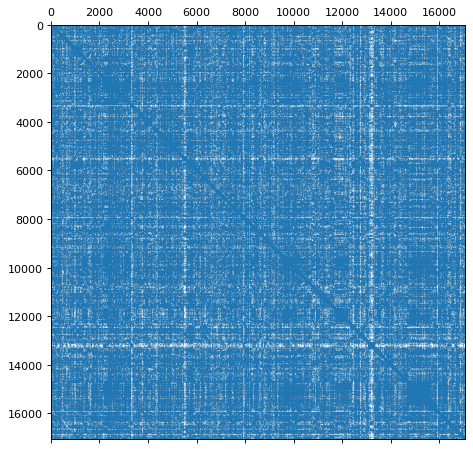

In [ ]:
# Vidualize similarity between books
plt.figure(figsize=(6, 6), dpi=80)
plt.spy(book_cosine_sim, precision = 0.1, markersize = 0.04)
plt.tight_layout()
plt.show()

---
---
# Recommendation
Purpose is: given a book name, find top `n` similar books based on cosine similarity score. In real use cases, the input book could be the book a user has read, has rated highly or have added to the read later list.
Books are recommended utilising the following information through keywords:

In [ ]:
books = pd.Series(model_data['Name'])

def recommend_books_similar_to(book_name, n=5, cosine_sim_mat=book_cosine_sim):
    # get index of the imput book
    if book_name not in books.values:
        return f"Book '{book_name}' not found in the dataset."
    input_idx = books[books == book_name].index[0]
    # Find top n similar books with decreasing order of similarity score
    top_n_books_idx = list(pd.Series(cosine_sim_mat[input_idx]).sort_values(ascending = False).iloc[1:n+1].index)
    # [1:6] to exclude 0 (index 0 is the input movie itself)

    books_list = list(books)
    recommended_books = [books[i] for i in top_n_books_idx]

    return recommended_books

## 1. Series Information
- Suggest other books from the similar series.
- In the example, series information **images of america** is used to recommend books relating to different parts of America from the same series (new jersey). As the background of the given book is set in chicago, another book based on chicago is (**altgeld's america**) is suggested. Book **cell** is recommended because the protagonist of the book is in Boston (from the Description).   

In [ ]:
# Recommendations with series information
print("\033[1m{}\033[0m".format("Recommendation (Series Information) based on the read: The Eastland Disaster (Images of America: Illinois)"))
display(recommend_books_similar_to("the eastland disaster (images of america: illinois)", 5))

Recommendation (Series Information) based on the read: The Eastland Disaster (Images of America: Illinois)


"Book 'the eastland disaster (images of america: illinois)' not found in the dataset."

## 2. Other Books In Numbered Series
- Suggest other books in the sequence from the same series.
- In the example below, other books in the series sequence of **Antique Lover** are recommended.

In [ ]:
# Recommendations with series information numbered
print("\n\033[1m{}\033[0m".format("Recommendation (Numbered Series) based on the read: The Majolica Murders (Antique Lover, #5)"))
display(recommend_books_similar_to("the majolica murders (antique lover, #5)", 5))


Recommendation (Numbered Series) based on the read: The Majolica Murders (Antique Lover, #5)


['the marriage casket (antique lover, #3)',
 'four on the floor (antique lover, #4)',
 'the weedless widow (antique lover, #2)',
 'cruel and unusual intuition (karma crime mystery, #3)',
 'caught dead']

## 3.Theme
- Utilise keywords depicting semantic meaning of the theme of the book to suggest books from similar themes.
- In the example below, all the books about developing programming skills irrespective of programming language are recommended.

In [ ]:
print("\n\033[1m{}\033[0m".format("Recommendation (Theme: Programming) based on the read: The Practice of Programming (Addison-Wesley Professional Computing Series)"))
display(recommend_books_similar_to('the practice of programming (addison-wesley professional computing series)', 5))


Recommendation (Theme: Programming) based on the read: The Practice of Programming (Addison-Wesley Professional Computing Series)


['c++ in plain english',
 'the c++ programming language',
 'data structures & other objects using java',
 'sams teach yourself beginning programming in 24 hours',
 'perl for dummies']

## 4. Author
- Suggest other works of the same Author.

In [ ]:
print("\n\033[1m{}\033[0m".format("Recommendation (Author: Dean Koontz) based on the read: Cold Fire"))
display(recommend_books_similar_to("cold fire",5))


Recommendation (Author: Dean Koontz) based on the read: Cold Fire


['false memory',
 'angels dance and angels die: the tragic romance of pamela and jim morrison',
 'quarantine',
 'papa jack: jack johnson and the era of white hopes',
 'x-rated: the mitchell brothers: a true story of sex, money, and death']

# References
- [Goodreads Book Datasets With User Rating 2M, n.d.](https://www.kaggle.com/datasets/bahramjannesarr/goodreads-book-datasets-10m?select=book1000k-1100k.csv)
- [GitHub - MaartenGr/KeyBERT: Minimal keyword extraction with BERT, n.d.](https://github.com/MaartenGr/KeyBERT)
- [GitHub - emonson/altair-vis-python: Visualization in Altair with Python workshop, n.d.](https://github.com/emonson/altair-vis-python)